### Churn prediction and clustering

In this script we try to predict whether a customer will churn (end their subscription). We also check if the customers can be clustered according to churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('../data/churn_data.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Can drop ID
data_prep = data.copy()
data_prep.drop('customerID', axis=1, inplace=True)

# First turn every Yes/No column into 1/0. In case you have something like 'No phone service', just make it 0 too
for col in ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']:
    data_prep[col] = data_prep[col].apply(lambda x: 1 if x == 'Yes' else 0)

# For Gender, InternetService, and PaymentMethod, we can use one-hot encoding
data_prep = pd.get_dummies(data_prep, columns=['gender', 'InternetService', 'PaymentMethod'], dtype=int)

# Do nominal encoding for Contract
#print(data_prep['Contract'].unique())
data_prep['Contract'] = data_prep['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

data_prep.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
1,0,0,0,34,1,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,1
2,0,0,0,2,1,0,1,1,0,0,...,1,0,1,1,0,0,0,0,0,1
3,0,0,0,45,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
4,0,0,0,2,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0


In [4]:
# An interesting feature to add might be the total number of services the customer has, i.e. the sum of PhoneService and InternetService, 
# as well as the extra features MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
data_prep['N_TotalServices'] = data_prep['PhoneService'] + data_prep['InternetService_DSL'] + data_prep['InternetService_Fiber optic'] + \
    data_prep['MultipleLines'] + data_prep['OnlineSecurity'] + data_prep['OnlineBackup'] + data_prep['DeviceProtection'] + \
    data_prep['TechSupport'] + data_prep['StreamingTV'] + data_prep['StreamingMovies']

# Another could be this total multiplied by the tenure, as a sort of total tenure
data_prep['N_TotalTenure'] = data_prep['N_TotalServices'] * data_prep['tenure']

# TotalCharge is a string, so we need to convert it to a number; no number means 0
data_prep['TotalCharges'] = pd.to_numeric(data_prep['TotalCharges'], errors='coerce').fillna(0)

data_prep.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,N_TotalServices,N_TotalTenure
0,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,2,2
1,0,0,0,34,1,0,1,0,1,0,...,1,1,0,0,0,0,0,1,4,136
2,0,0,0,2,1,0,1,1,0,0,...,1,1,0,0,0,0,0,1,4,8
3,0,0,0,45,0,0,1,0,1,1,...,1,1,0,0,1,0,0,0,4,180
4,0,0,0,2,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,2,4


In [5]:
# Split the data
X = data_prep.drop('Churn', axis=1)
y = data_prep['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Apply standard scaling to tenure, MonthlyCharges, TotalCharges, and N_TotalTenure
# Strictly speaking it won't change the XGBoost model, but it is useful for the clustering later
scaler = StandardScaler()
X_train[['tenure', 'MonthlyCharges', 'TotalCharges', 'N_TotalTenure']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges', 'N_TotalTenure']])
X_test[['tenure', 'MonthlyCharges', 'TotalCharges', 'N_TotalTenure']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges', 'N_TotalTenure']])
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,N_TotalServices,N_TotalTenure
2142,0,0,1,-0.465683,1,0,1,0,1,0,...,0,1,0,0,0,0,0,1,5,-0.323037
1623,0,0,0,0.885537,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,6,0.927581
6074,0,1,0,-1.284605,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,-0.916938
1362,0,0,0,-1.161766,1,0,0,0,0,0,...,1,0,1,0,0,0,1,0,2,-0.876964
6754,0,0,1,-1.325551,1,1,1,1,0,1,...,1,1,0,0,1,0,0,0,6,-0.922649


In [7]:
# Train the model
model = XGBClassifier(n_estimators=1000, learning_rate=0.1, n_jobs=-1, early_stopping_rounds=5, random_state=42)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.808374733853797


In [8]:
# Optimise
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

max_acc = 0
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=-1, early_stopping_rounds=5, random_state=42)
        model.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  verbose=False)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'n_estimators: {n_estimators}, learning_rate: {learning_rate}, accuracy: {accuracy}')
        if accuracy > max_acc:
            max_acc = accuracy
print(f'Max accuracy: {max_acc}')

n_estimators: 100, learning_rate: 0.01, accuracy: 0.7998580553584103
n_estimators: 100, learning_rate: 0.05, accuracy: 0.8062455642299503
n_estimators: 100, learning_rate: 0.1, accuracy: 0.808374733853797
n_estimators: 100, learning_rate: 0.15, accuracy: 0.8076650106458482
n_estimators: 500, learning_rate: 0.01, accuracy: 0.8076650106458482
n_estimators: 500, learning_rate: 0.05, accuracy: 0.8062455642299503
n_estimators: 500, learning_rate: 0.1, accuracy: 0.808374733853797
n_estimators: 500, learning_rate: 0.15, accuracy: 0.8076650106458482
Max accuracy: 0.808374733853797


Best score seems to be 100 estimators, 0.1 rate with 0.8084 accuracy.

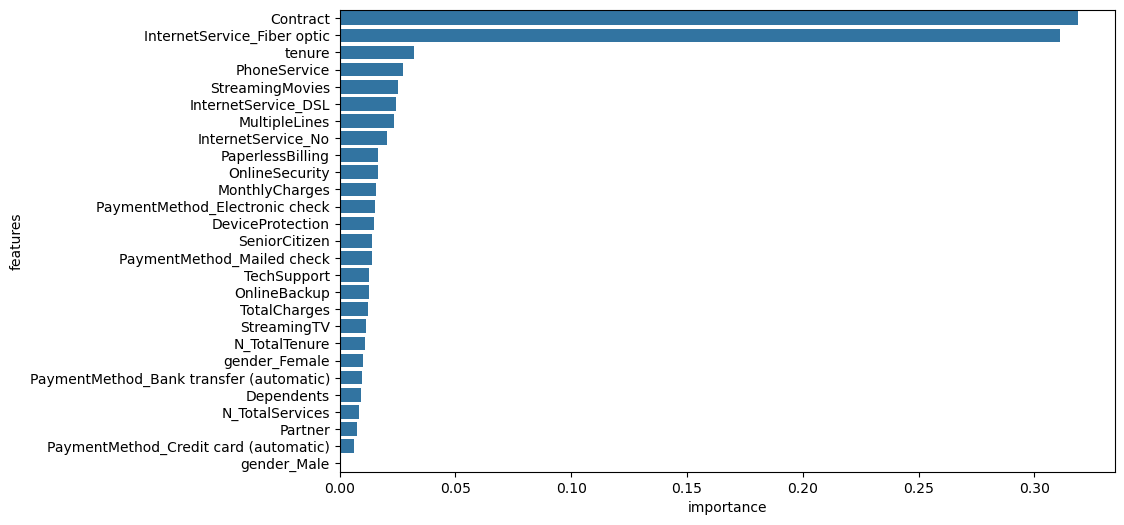

In [9]:
# Check feature importance (might be useful for clustering)
feature_importance = model.feature_importances_
features = X.columns
df = pd.DataFrame({'features': features, 'importance': feature_importance})
df = df.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='features', data=df)
plt.show()

So the contract type is very important. It might be that people with month-to-month contracts are more likely to cancel, as they can do so more often. Check the plot.

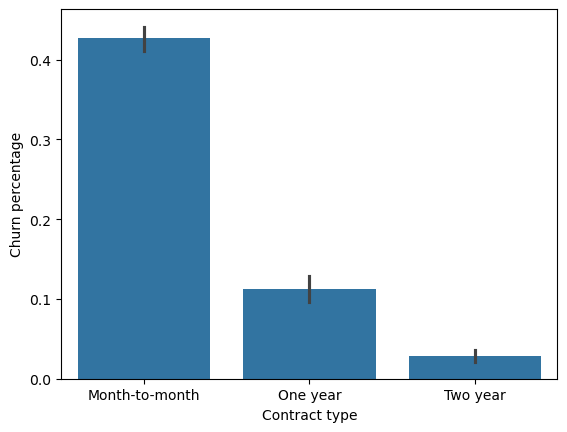

In [10]:
# Plot for each contract type how many people churned
sns.barplot(x='Contract', y='Churn', data=data_prep)
plt.xticks(ticks=[0, 1, 2], labels=['Month-to-month', 'One year', 'Two year'])
plt.xlabel('Contract type')
plt.ylabel('Churn percentage')
plt.show()

So that is indeed the case. Then another very important feature is the Fiber optic. Maybe it is so terrible that anyone who gets it wants out.

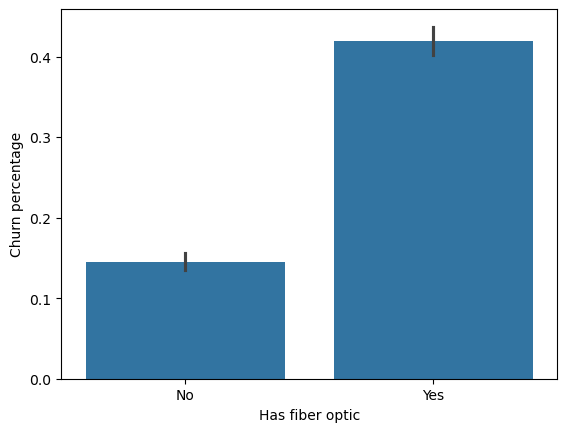

In [11]:
sns.barplot(x='InternetService_Fiber optic', y='Churn', data=data_prep)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.xlabel('Has fiber optic')
plt.ylabel('Churn percentage')
plt.show()

That seems to be the case as well. Or at least, like 42% of people who have it quit.

Check if the model improves using only the most important features.

In [12]:
best_feat = df['features'].values[:7]
X_train_selected = X_train[best_feat]
X_test_selected = X_test[best_feat]

# Train the model
model = XGBClassifier(n_estimators=1000, learning_rate=0.1, n_jobs=-1, early_stopping_rounds=5, random_state=42)
model.fit(X_train_selected, y_train,
          eval_set=[(X_test_selected, y_test)],
          verbose=False)
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7998580553584103


So it becomes slightly less accurate actually.

Then look at clustering.

In [13]:
samples = data_prep.drop('Churn', axis=1).values

scaler = StandardScaler()
samples_scaled = scaler.fit_transform(samples)

# Use 2 clusters, for churn and no churn
cluster_model = KMeans(n_clusters=2, random_state=42)
cluster_model.fit(samples_scaled)
labels = cluster_model.predict(samples_scaled)

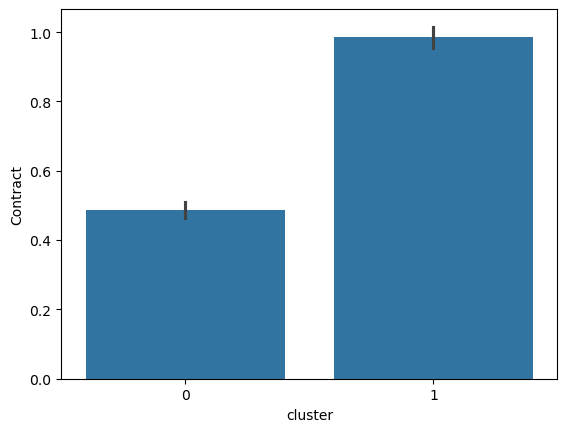

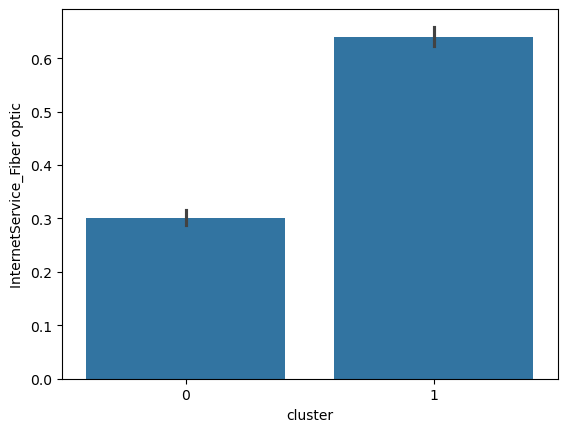

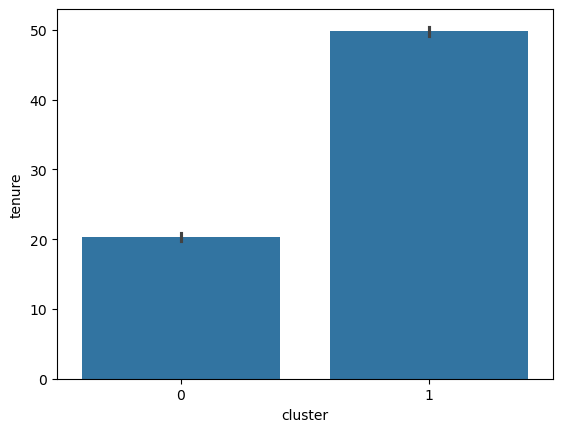

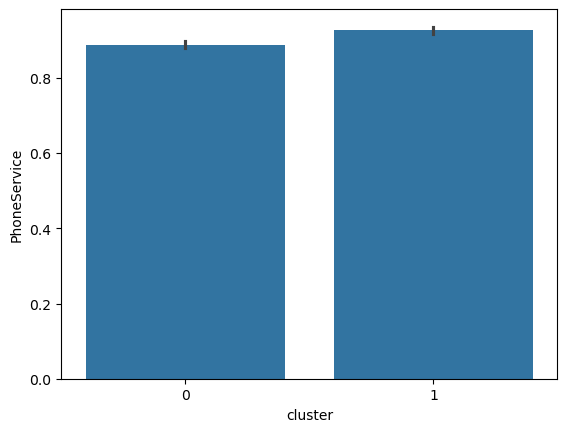

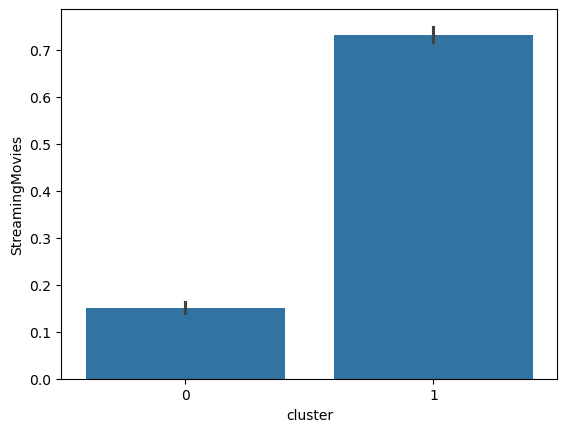

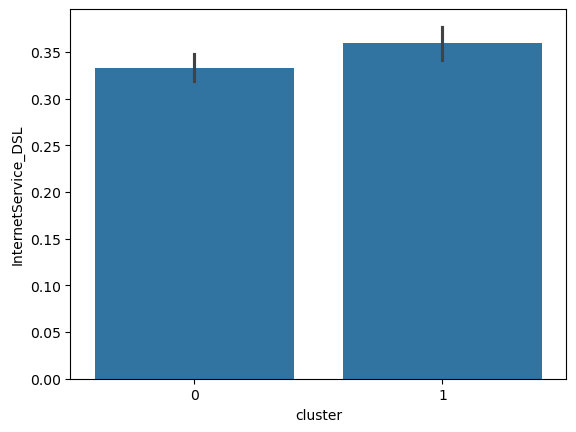

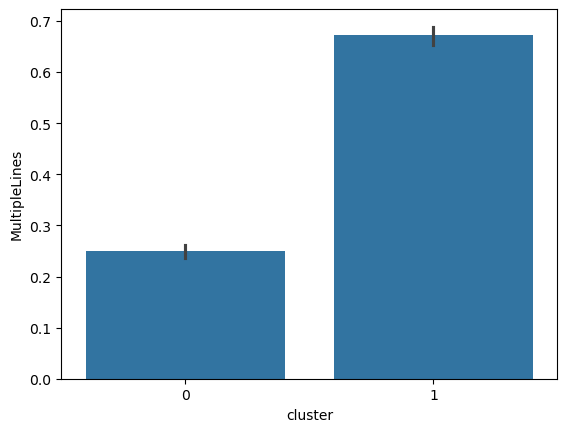

In [26]:
# Make plots
data_prep['cluster'] = labels
for col in list(best_feat):
    sns.barplot(x='cluster', y=col, data=data_prep) #, hue='Churn')
    plt.show()

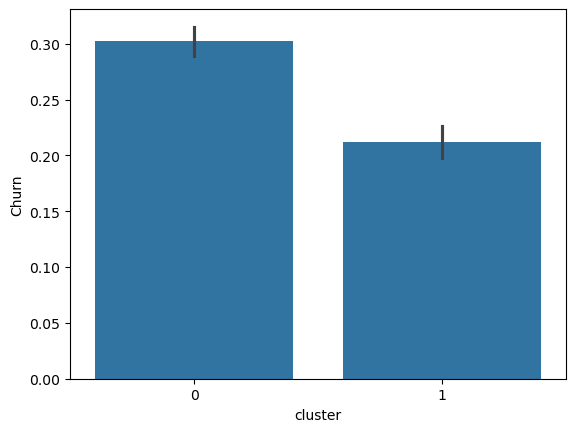

In [25]:
sns.barplot(x='cluster', y='Churn', data=data_prep)
plt.show()

In [ ]:
# What we plot is the average of the Churn column, i.e. the percentage of people that churned, for each cluster label.
# In a perfect result, one cluster would have 0% churn, and the other 100%.
data_prep.groupby('cluster')["Churn"].sum() / data_prep.groupby('cluster')["Churn"].size()

cluster
0    0.302158
1    0.211974
Name: Churn, dtype: float64

In the last plot it is clear that the created clusters do not correspond that well to the actual churn. (Also it seems like cluster label 0 corresponds to actual churn, with value 1, as the average churn value is largest for cluster label 0. So that's unfortunate.)

In the other plots you can see that the clusters seem not to care much about e.g. the PhoneService variable, as the average is the same. Other variables are important, mostly StreamingMovies.

In the end, it seems like clustering is not so helpful here. But the XGBoost model works fairly well.